In [105]:
import pandas as pd

naruto = pd.read_csv('Datacamp CSV/Naruto_Reviews.csv', index_col = 0)

# No, it worked! It was just some guy who wrote literally the exact same review
# Current problem is that we have too few reviews on MAL, and too many words. 
# Try using a stemmer to help reduce number of words. UPDATE: Looks like it still doesn't
# really work. That's unfortunate, but at least you can see what words are associated with a
# positive Naruto review!

# Categorise the reviews by positive or negative. Positive if 7+, Negative if 6-
naruto['verdict'] = np.where(naruto['score'] > 6, 'positive', 'negative')
naruto['helpful'] = naruto['helpful'].astype(int)
naruto['score'] = naruto['score'].astype(int)
naruto.sort_values(['helpful'], ascending = False)

,date,seen,score,helpful,review,verdict
60,"Apr 27, 2008",220 of 220 episodes seen,7,1060,"To be honest, Naruto is the most overhyped sh...",positive
61,"Jun 25, 2008",220 of 220 episodes seen,7,730,I began to browse through the reviews of Naru...,positive
62,"Dec 3, 2011",220 of 220 episodes seen,10,344,"Naruto, yes Naruto. One of the series that ha...",positive
63,"Apr 30, 2011",220 of 220 episodes seen,8,321,"I'm sure most, if not all, the people who end...",positive
64,"Dec 18, 2014",220 of 220 episodes seen,4,227,I would like to start this review off by sayi...,negative
...,...,...,...,...,...,...
327,"Apr 19, 2020",220 of 220 episodes seen,6,0,CAUTION: THIS IS A REVIEW - a formal assessme...,negative
328,"Sep 21, 2013",220 of 220 episodes seen,7,0,Naruto is one of those animes that everyone h...,positive
329,"Jul 10, 2020",220 of 220 episodes seen,8,0,This is when the series is still about Ninjas...,positive
330,"Oct 20, 2017",220 of 220 episodes seen,5,0,Naruto is another in a long-line of popular s...,negative


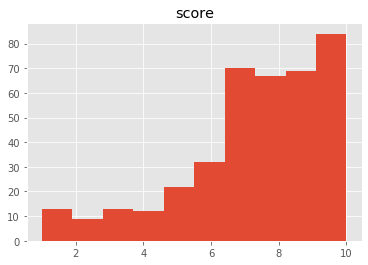

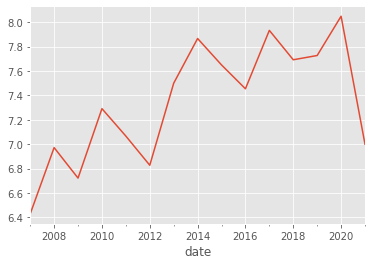

In [62]:
# Some preliminary EDA
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Distribution of Naruto scores
naruto.hist('score')
plt.show()

# Naruto scores over time
naruto['date'] = pd.to_datetime(naruto['date'])

naruto.set_index('date').resample('Y')['score'].mean().plot()
plt.show()

In [95]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
# Stemmer a word effectively means reducing it to its root word.
words = ['friends', 'friendship', 'friend', 'friendly']

porter = PorterStemmer()

for word in words:
    print(porter.stem(word))

# Stemming doesn't work on sentences - a stemmer will think the entire sentence is a word
# We need to read in the sentence, tokenize it, then stem it.
def stemSentence(sentence):
    # Tokenize the sentence
    token_words=word_tokenize(sentence)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in token_words if not w in stop_words]
    
    # Stem each word and reform the document.
    stem_sentence=[]
    for word in filtered_sentence:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

# Let's stem each review and do the machine learning again
naruto['stemmed_review'] = naruto['review'].apply(stemSentence)

naruto

friend
friendship
friend
friendli


,date,seen,score,helpful,review,verdict,stemmed_review
0,"Jun 11, 2011",220 of 220 episodes seen,8,8,I originally refused to watch the Naruto seri...,positive,I origin refus watch naruto seri togeth simpli...
1,"Jun 17, 2009",138 of 220 episodes seen,7,8,"All right, first review on the site, and prob...",positive,"all right , first review site , probabl last o..."
2,"Jan 13, 2020",140 of 220 episodes seen,2,3,Essa review contém spoilers. This review cont...,negative,essa review contém spoiler . thi review contai...
3,"Dec 17, 2019",124 of 220 episodes seen,8,3,"Okay, to be honest, I can't really say anythi...",positive,"okay , honest , I ca n't realli say anyth mani..."
4,"Nov 12, 2019",220 of 220 episodes seen,7,3,"Well, I finally did it. After watching 220 ep...",positive,"well , I final . after watch 220 episod I fina..."
...,...,...,...,...,...,...,...
386,"Dec 30, 2020",220 of 220 episodes seen,8,0,Here is a very honest review of my experience...,positive,"here honest review experi show , gon na keep s..."
387,"Jan 3, 2021",220 of 220 episodes seen,10,0,"*Not going to be in depth or specific. Also, ...",positive,"*not go depth specif . also , I watch naruto g..."
388,"Sep 11, 2013",220 of 220 episodes seen,7,0,A good story with a diverse cast of character...,positive,A good stori divers cast charact plagu constan...
389,"Nov 9, 2020",51 of 220 episodes seen,10,0,"To be honest, Naruto is the most overhyped sh...",positive,"To honest , naruto overhyp show exist . everyo..."


In [102]:
# Get our features and target variable
X = naruto['stemmed_review']
y = naruto['verdict']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,
                                                    test_size = 0.1, 
                                                    random_state = 123)

# Note that this gets only alphabets, NOT numbers.
alphanumeric = '[A-Za-z]+(?=\\s+)'

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2

# Create our pipeline. 
pipeline = Pipeline([('vectorizer', CountVectorizer(token_pattern = alphanumeric, 
                                                    stop_words = 'english', 
                                                    ngram_range = (1,2))), 
                     ('transformer', TfidfTransformer()),
                     ('classifier', LogisticRegression(C = 10, solver = 'newton-cg'))
                    ])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='[A-Za-z]+(?=\\s+)',
                                 tokenizer=None, voc...
                ('transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=10, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_sc

In [101]:
from sklearn.model_selection import GridSearchCV

params = {
    'classifier__C': [100.0, 10.0, 1.0, 0.1, 0.01, 0.001],
    'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg']
}

search = GridSearchCV(pipeline, params, cv = 3, scoring='neg_log_loss', verbose = 1, n_jobs = -1)
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    9.3s finished


{'classifier__C': 10.0, 'classifier__solver': 'newton-cg'}
-0.4894896325826042


In [103]:
predictions = pipeline.score(X_test, y_test)
predictions

0.775

In [104]:
# Get the vocabulary found in the reviews.
vocab = pipeline['vectorizer'].get_feature_names()

# This finds out what the coeffients used to fit the model are, from the most negative to
# most positive.
# Each coefficient used to help predict. A positive helps predict the positive class, etc.
coefs = pipeline['classifier'].coef_.flatten()
inds_ascending = np.argsort(coefs) 
inds_descending = inds_ascending[::-1]

print("Most positive words: ", end="")
for i in range(21):
    print(vocab[inds_descending[i]], end=", ")
print("\n")

print("Most negative words: ", end="")
for i in range(1, 21):
    print(vocab[inds_ascending[i]], end=", ")
print("\n")

Most positive words: love, naruto, great, mani, amaz, alway, shippuden, music, perfect, emot, best, filler, lot, realli, watch naruto, uniqu, sad, best anim, villag, differ, skip filler, 

Most negative words: quot, worst, pace, anyth, t, oh, slow, mediocr, wear, tend, half, annoy, use, fact, decent, drag, plot, suppos, damn, bad, 



In [107]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Collect all the positive reviews
positive_reviews = " ".join(review for review in naruto[naruto['score'] > 7]['review'])

stop_words = set(stopwords.words('english'))
stop_words.update(["anime", "show", "character", "characters", "get", "like", "also"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stop_words, 
                      background_color="white",
                     width=800, height=400).generate(positive_reviews)

%matplotlib qt
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()